In [100]:
!pip install tesserocr-2.7.0-cp39-cp39-win_amd64.whl

Processing c:\users\owner\documents\jupyter\code\research\tesserocr-2.7.0-cp39-cp39-win_amd64.whl
  Attempting uninstall: tesserocr
    Found existing installation: tesserocr 2.7.0
    Uninstalling tesserocr-2.7.0:
      Successfully uninstalled tesserocr-2.7.0


In [708]:
import matplotlib.pyplot as plt 
import cv2
import numpy as np
import re
import math
import tesserocr

from tesserocr import PyTessBaseAPI, RIL, iterate_level
from PIL import Image, ImageDraw, ImageFont

In [709]:
#sample text
text ="TH15 guy 15 @n 1d10t m@n"
text

'TH15 guy 15 @n 1d10t m@n'

In [710]:
word_tokens = text.split()
word_tokens

['TH15', 'guy', '15', '@n', '1d10t', 'm@n']

In [711]:
def is_alphabet(char):
    pattern = r'^[A-Za-z]$'     #check if char is English Alphabet
    return bool(re.fullmatch(pattern, char))

non_alphabet = []

for i in range(len(word_tokens)):
    word = list(word_tokens[i])
    
    for j in range(len(word)):
        if not is_alphabet(word[j]):
            non_alphabet.append(word[j])
            word[j] = '*'
    
    word_tokens[i] = ''.join(word)

print("Modified list:", word_tokens)
print("Non-alphabet characters:", non_alphabet)

Modified list: ['TH**', 'guy', '**', '*n', '*d**t', 'm*n']
Non-alphabet characters: ['1', '5', '1', '5', '@', '1', '1', '0', '@']


In [712]:
def img_filter(img):
    img = np.array(img)
    kernel = np.ones((5, 5), np.uint8) 

    img = cv2.GaussianBlur(img,(5,5),0)
    ret, img = cv2.threshold(img, 130, 255, cv2.THRESH_BINARY) 
    
    
    img=Image.fromarray(img)
    
    return img

In [713]:
def char_to_image(character):
    img_size=(30,30)
    font_size=30
    img = Image.new('RGB', img_size,color='white')
    
    draw = ImageDraw.Draw(img)
    
    font=ImageFont.truetype("tahoma", font_size)
    
    (left, top, right, bottom) = font.getbbox(character)
    
    char_w = right - left
    char_h = bottom - top
    
    position = ((img_size[0] - char_w) // 2, ((img_size[1] - char_h) // 2)-top)
    draw.text(position, character,fill='black',font=font)
        
    img=img_filter(img)
    
    return img

In [714]:
img_list=[]

for i in range(len(non_alphabet)):
    img = char_to_image(non_alphabet[i])
    img_list.append(img)

In [715]:
def display_images(images):
    rows = math.ceil(len(images) / 5)
    fig = plt.figure(figsize=(12, 10))

    for i in range (len(images)):
        fig.add_subplot(rows,5,i+1)
        plt.imshow(images[i], cmap = 'gray')
    
    plt.subplots_adjust(wspace=0.3, hspace=-0.3)
    plt.show()

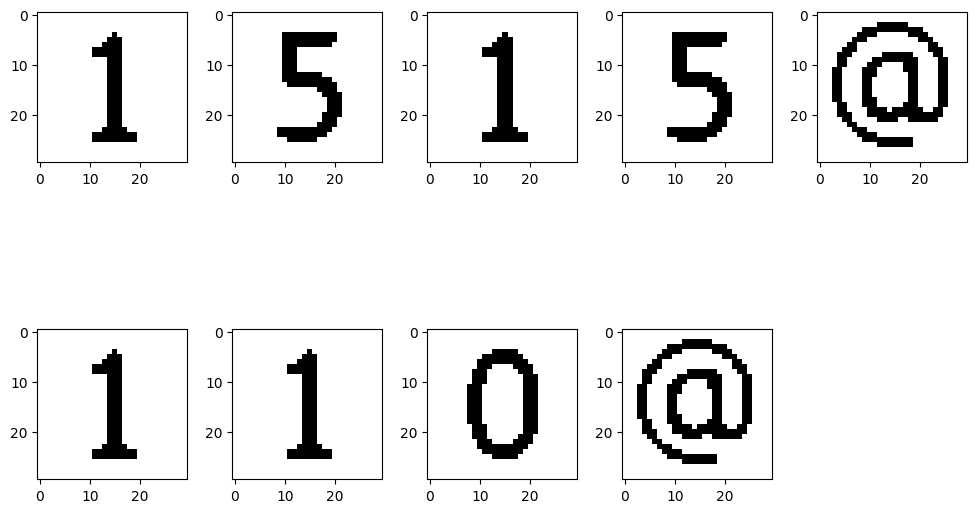

In [716]:
display_images(img_list)

In [717]:
def get_choices(images):
    try:
        candidate = []
        with PyTessBaseAPI(psm=tesserocr.PSM.SINGLE_CHAR) as api:
            api.SetVariable("lstm_choice_mode", "2")
            api.SetVariable("tessedit_char_whitelist", "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz")
            api.SetVariable("lstm_choice_iterations", "5")
            api.SetImage(img)
            api.Recognize()

            ri = api.GetIterator()
            level = RIL.SYMBOL

            for r in iterate_level(ri, level):
                symbol = r.GetUTF8Text(level)  # r == ri
                char_pred=symbol

                ci = r.GetChoiceIterator()
                for c in ci:
                    choice = c.GetUTF8Text()  # c == ci
                    conf= c.Confidence()
                    candidate.append((choice,conf))


        return char_pred, candidate
    except Exception as e:
        return "", []

In [718]:
predictions = []
char_candidates = []

for img in img_list:
    char_pred, candidate = get_choices(img)
    predictions.append(char_pred)
    char_candidates.append(candidate)


In [719]:
print("Before prediction: ", non_alphabet)
print("After prediction: ", predictions,"\n")

for i in range(len(non_alphabet)):
    print("Predicted characters for: '",non_alphabet[i],"'")
    print("\t",char_candidates[i])
    print("\n")

Before prediction:  ['1', '5', '1', '5', '@', '1', '1', '0', '@']
After prediction:  ['l', 'S', 'l', 'S', 'a', 'l', 'l', 'O', 'a'] 

Predicted characters for: ' 1 '
	 [('l', 22.42507553100586), ('I', 4.816093444824219), ('g', 0.0), ('a', 0.0), ('s', 0.0), ('e', 0.0)]


Predicted characters for: ' 5 '
	 [('S', 10.30888557434082), ('I', 0.0)]


Predicted characters for: ' 1 '
	 [('l', 22.42507553100586), ('I', 4.816093444824219), ('g', 0.0), ('a', 0.0), ('s', 0.0), ('e', 0.0)]


Predicted characters for: ' 5 '
	 [('S', 10.30888557434082), ('I', 0.0)]


Predicted characters for: ' @ '
	 [('Q', 90.8500747680664), ('a', 79.69709777832031), ('q', 53.899200439453125), ('d', 45.12533187866211), ('g', 44.76344299316406), ('A', 33.02405548095703), ('Q', 92.4271011352539), ('a', 76.3775634765625), ('q', 46.614707946777344), ('d', 45.39847946166992), ('g', 44.568023681640625), ('A', 33.780521392822266)]


Predicted characters for: ' 1 '
	 [('l', 22.42507553100586), ('I', 4.816093444824219), ('g', 

In [720]:
def replace_char(word_tokens, predictions,non_alphabet):
    k=0
    
    for i in range(len(word_tokens)):
        word = list(word_tokens[i])
    
        for j in range(len(word)):
            if word[j]=='*':
                if k<(len(predictions)):
                    if predictions[k] != "":
                        word[j] = predictions[k]
                        k+=1
                    else:
                        word[j] = non_alphabet[k]
                        k+=1
                else:
                    break
    
        word_tokens[i] = ''.join(word)
        
    return word_tokens

In [721]:
replace_char(word_tokens, predictions,non_alphabet)

['THlS', 'guy', 'lS', 'an', 'ldlOt', 'man']